In [5]:
from dateutil import tz
from pynwb import NWBFile
from datetime import datetime

from jdb_to_nwb.convert_raw_ephys import add_electrode_data, add_raw_ephys, get_raw_ephys_data, get_raw_ephys_metadata

# Set up dummy metadata
metadata = {}
metadata["ephys"] = {}
metadata["ephys"]["openephys_folder_path"] = "/Volumes/Tim/Neuropixel2.0/openephys_data/sync_and_probe2025-05-08_00-07-51"
metadata["ephys"]["impedance_file_path"] = ""
metadata["ephys"]["electrodes_location"] = "Hippocampus CA1"
metadata["ephys"]["targeted_x"] = 4.5  # AP in mm
metadata["ephys"]["targeted_y"] = 2.2  # ML in mm
metadata["ephys"]["targeted_z"] = 2.0  # DV in mm
metadata["ephys"]["probe"] = ["Neuropixels 2.0 (4-shank)"]

# Set up dummy logger that just prints stuff
class DummyLogger:
    def debug(self, msg):
        print(f"[DEBUG] {msg}")
        
    def info(self, msg):
        print(f"[INFO] {msg}")

    def warning(self, msg):
        print(f"[WARNING] {msg}")

logger = DummyLogger()

# Set up dummy nwbfile for Neuropixels
nwbfile = NWBFile(
    session_description="Test of Neuropixels 1.0 to NWB",
    session_start_time=datetime.now(tz.tzlocal()),
    identifier="npx_test_session",
)

# Try add raw ephys
add_raw_ephys(nwbfile=nwbfile, metadata=metadata, logger=logger)


Adding raw ephys...
[INFO] Adding raw ephys...
[INFO] Open Ephys start time: 2025-05-08 00:07:51-07:00
[DEBUG] Found streams in the OpenEphys binary data: [np.str_('Record Node 114#OneBox-100.OneBox-ADC'), np.str_('Record Node 114#OneBox-100.slot16-port1-1')]
[DEBUG] Found 384 Open Ephys channels to convert: ['CH0' 'CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64' 'CH65' 'CH66' 'CH67' 'CH68' 'CH69' 'CH70' 'CH71'
 'CH72' 'CH73' 'CH74' 'CH75' 'CH76' 'CH77' 'CH78' 'CH79' 'CH80' 'CH81'
 'CH82' 'CH83' 'CH84' 'CH85' 'CH86' 'CH87' 'CH88' 'CH89' 'CH90' 'CH91'
 'CH92' 'CH93' 'CH94' 'CH95' 'CH96' 'CH97' 'CH9

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Tim/Neuropixel2.0/openephys_data/sync_and_probe2025-05-08_00-07-51/settings.xml'

In [ ]:
from spikeinterface.extractors import OpenEphysBinaryRecordingExtractor

MICROVOLTS_PER_VOLT = 1e6
VOLTS_PER_MICROVOLT = 1 / MICROVOLTS_PER_VOLT

folder_path =  "/Volumes/Tim/Neuropixel2.0/openephys_data/sync_and_probe2025-05-08_00-07-51"

# Create a SpikeInterface recording extractor for the OpenEphys binary data
streams, _ = OpenEphysBinaryRecordingExtractor.get_streams(folder_path=folder_path)
logger.debug(f"Found streams in the OpenEphys binary data: {streams}")

streams_without_adc = [s for s in streams if not s.endswith("ADC")]
assert len(streams_without_adc) == 1, \
    (f"More than one non-ADC stream found in the OpenEphys binary data: {streams_without_adc}")

# Note that for bilateral Neuropixels we will have 2 streams without ADC (one for each probe)
# We will deal with this later. Probably just do all of the following in a loop (once per probe)?

# Ignore the "ADC" channels
recording = OpenEphysBinaryRecordingExtractor(folder_path=folder_path, stream_name=streams_without_adc[0])
channel_ids_to_convert = [ch for ch in recording.channel_ids if ch.startswith("CH")]
recording_sliced = recording.select_channels(channel_ids=channel_ids_to_convert)
logger.debug(f"Recording info: {recording_sliced}")

# Confirm all channel names start with "CH"
assert all([ch.startswith("CH") for ch in recording_sliced.channel_ids]), \
    (f"Some channels do not start with 'CH': {recording_sliced.channel_ids}")

logger.debug(
    f"Found {len(recording_sliced.channel_ids)} Open Ephys channels to convert: "
    f"{recording_sliced.channel_ids}"
)

# Get the channel conversion factor
channel_conversion_factors_uv = recording_sliced.get_channel_gains()
# Warn if the channel conversion factors are not the same for all channels
if not all(channel_conversion_factors_uv == channel_conversion_factors_uv[0]):
    print(
        "The channel conversion factors are not the same for all channels. "
        "This is unexpected and may indicate a problem with the conversion factors."
    )
    logger.warning(
        "The channel conversion factors are not the same for all channels. "
        "This is unexpected and may indicate a problem with the conversion factors."
    )
channel_conversion_factor_v = channel_conversion_factors_uv[0] * VOLTS_PER_MICROVOLT
logger.debug(f"Channel conversion factor in V: {channel_conversion_factor_v}")

# NOTE channel offsets should be 0 for all channels in openephys data
channel_conversion_offsets = recording_sliced.get_channel_offsets()
assert all(channel_conversion_offsets == 0), "Channel conversion offsets are not all 0."

# Get the original timestamps (in seconds)
original_timestamps = recording_sliced.get_times()

logger.debug(f"Open Ephys sampling frequency: {recording_sliced.get_sampling_frequency()}")

traces = recording_sliced.get_traces()
logger.debug(f"There are {traces.shape[1]} channels x {traces.shape[0]} samples")


# Create a SpikeInterfaceRecordingDataChunkIterator using all default buffering and
# chunking options. This will be passed to the pynwb.ecephys.ElectricalSeries
# constructor.
#traces_as_iterator = SpikeInterfaceRecordingDataChunkIterator(recording=recording_sliced)

[DEBUG] Found streams in the OpenEphys binary data: [np.str_('Record Node 114#OneBox-100.OneBox-ADC'), np.str_('Record Node 114#OneBox-100.slot16-port1-1')]
[DEBUG] Recording info: ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 60,647 samples - 2.02s - int16 dtype 
                       44.42 MiB
[DEBUG] Found 384 Open Ephys channels to convert: ['CH0' 'CH1' 'CH2' 'CH3' 'CH4' 'CH5' 'CH6' 'CH7' 'CH8' 'CH9' 'CH10' 'CH11'
 'CH12' 'CH13' 'CH14' 'CH15' 'CH16' 'CH17' 'CH18' 'CH19' 'CH20' 'CH21'
 'CH22' 'CH23' 'CH24' 'CH25' 'CH26' 'CH27' 'CH28' 'CH29' 'CH30' 'CH31'
 'CH32' 'CH33' 'CH34' 'CH35' 'CH36' 'CH37' 'CH38' 'CH39' 'CH40' 'CH41'
 'CH42' 'CH43' 'CH44' 'CH45' 'CH46' 'CH47' 'CH48' 'CH49' 'CH50' 'CH51'
 'CH52' 'CH53' 'CH54' 'CH55' 'CH56' 'CH57' 'CH58' 'CH59' 'CH60' 'CH61'
 'CH62' 'CH63' 'CH64' 'CH65' 'CH66' 'CH67' 'CH68' 'CH69' 'CH70' 'CH71'
 'CH72' 'CH73' 'CH74' 'CH75' 'CH76' 'CH77' 'CH78' 'CH79' 'CH80' 'CH81'
 'CH82' 'CH83' 'CH84' 'CH85' 'CH86' 'CH87' 'CH88' 'CH89' 'CH90' '

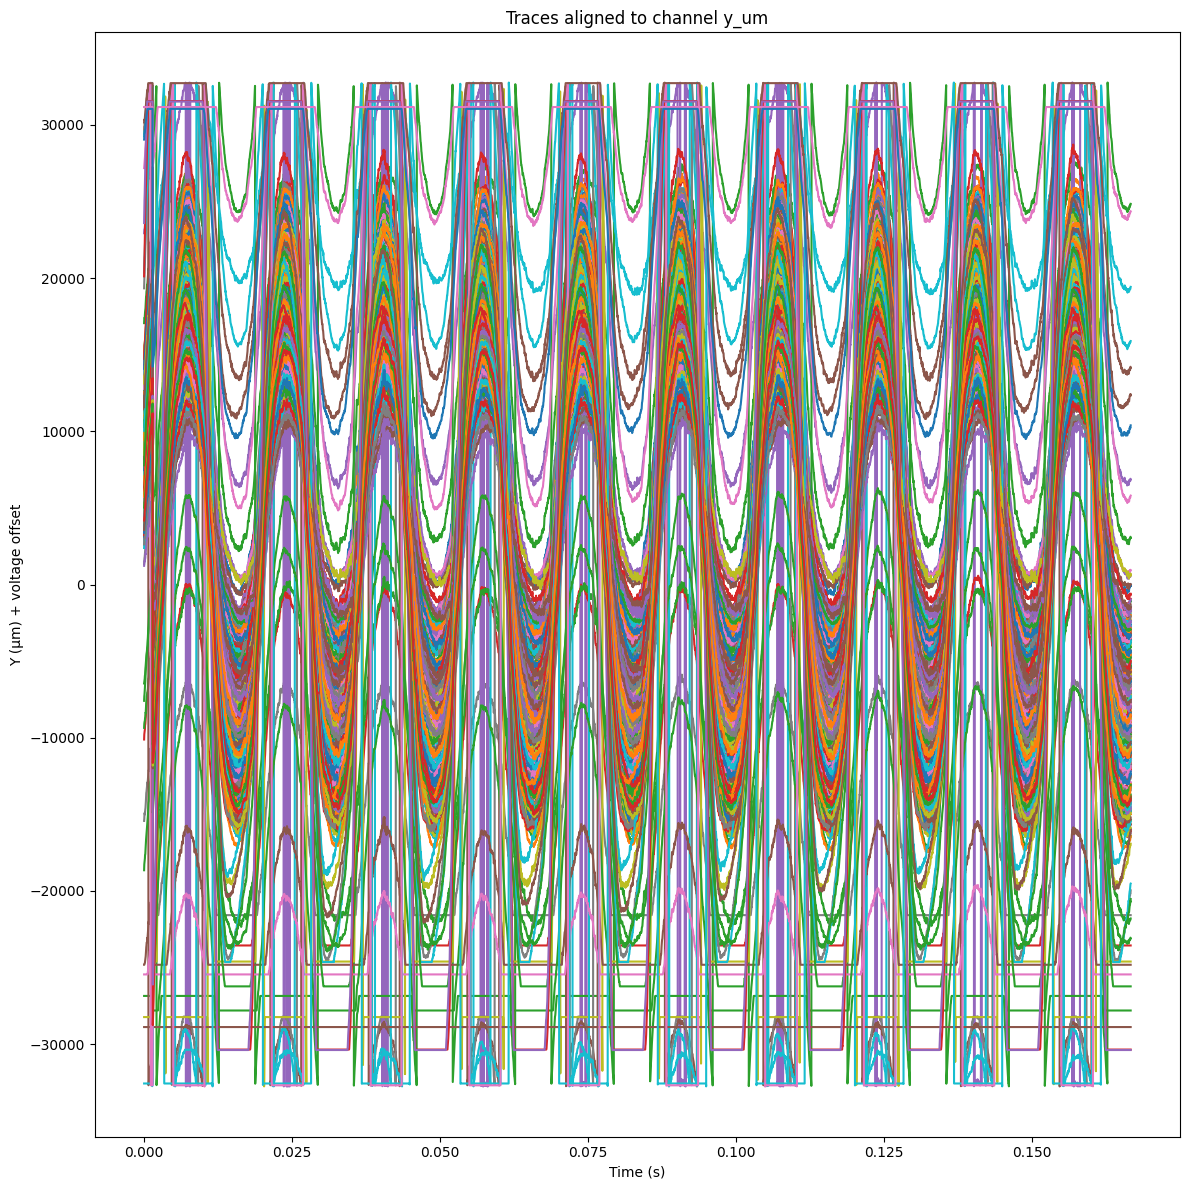

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load channel metadata from CSV
channel_df = pd.read_csv("resources/shank1_saline_tip2025-06-06_14-42-51_electrode_info.csv")

# Make sure channel_name in channel_df is str like "CH0", "CH1", etc.
channel_df["channel_name"] = channel_df["channel_name"].astype(str)

# Build a DataFrame mapping traces to y_um
trace_map_df = pd.DataFrame({
    "channel_name": recording_sliced.channel_ids
})
trace_map_df = trace_map_df.merge(channel_df[["channel_name", "y_um"]], on="channel_name", how="left")

# Check for missing matches
if trace_map_df["y_um"].isnull().any():
    missing = trace_map_df[trace_map_df["y_um"].isnull()]
    raise ValueError(f"Missing y_um for channels: {missing['channel_name'].tolist()}")

# Sort by y_um for visualization (optional)
trace_map_df["channel_index"] = np.arange(len(trace_map_df))
trace_map_df = trace_map_df.sort_values(by="y_um", ascending=False).reset_index(drop=True)

# Reorder traces to match y_um
traces_ordered = traces[:, trace_map_df["channel_index"]]

# Plot (e.g., first 1000 samples)
time = np.arange(traces.shape[0]) / recording_sliced.get_sampling_frequency()

plt.figure(figsize=(12, 12))
offset = 300  # spacing between traces in µV
for i, (ch_name, y) in enumerate(zip(trace_map_df["channel_name"], trace_map_df["y_um"])):
    trace = traces_ordered[:5000, i]
    plt.plot(time[:5000], trace + y, label=ch_name)

plt.xlabel("Time (s)")
plt.ylabel("Y (µm) + voltage offset")
plt.title("Traces aligned to channel y_um")
plt.tight_layout()
plt.show()
